Make that we are running the correct version of TensorFlow first

In [1]:
import tensorflow as tf
tf.__version__

/home/jupyter/.local/share/virtualenvs/line-reader-3vKrZmrE/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jupyter/.local/share/virtualenvs/line-reader-3vKrZmrE/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jupyter/.local/share/virtualenvs/line-reader-3vKrZmrE/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtyp

'2.0.0-beta1'

In [2]:
import sys

assert sys.version_info >= (3, 6) # Python ≥3.6 required
assert tf.__version__ >= "2.0"    # TensorFlow ≥2.0 required

# Build a lines segmentation model based on unet architecture 

Here is [the paper](https://arxiv.org/pdf/1505.04597.pdf)

In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('..')

from pathlib import Path
Path.ls = lambda x: list(x.iterdir())  # Source: https://github.com/fastai/fastai/blob/master/fastai/core.py#L236

from tqdm import tqdm

from PIL import Image

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical

In [4]:
from recognizer.datasets import Dataset
from recognizer.networks import unet
from recognizer.networks import NetworkInput

In [5]:
lines_detector_path = Dataset.processed_data_path()/"lines_detector"
lines_detector_images_path = lines_detector_path/"images"
lines_detector_masks_path = lines_detector_path/"masks"

Hyperparameters

In [6]:
batch_size = 16
epochs = 5

In [7]:
model_save_path = Path("../recognizer/weights/lines_detector.h5")

## Load dataset

In [8]:
x = []
y = []

sorted_image_names = sorted(lines_detector_images_path.glob("*.jpg"))
sorted_mask_names = sorted(lines_detector_masks_path.glob("*.png"))
for image_file_name, mask_file_name in tqdm(zip(sorted_image_names, sorted_mask_names)):
    image = img_to_array(Image.open(image_file_name)) / 255
    mask = img_to_array(Image.open(mask_file_name), dtype=np.uint8) // 127
    
    x.append(image)
    y.append(mask)

x = np.array(x)
y = np.array(y)

# len(x), x[0].shape
x.shape

1539it [00:02, 628.31it/s]


(1539, 256, 256, 1)

In [9]:
x[0].dtype, y[0].dtype

(dtype('float32'), dtype('uint8'))

## Augment the data

## Build the model

In [10]:
np.unique(y)

array([0, 1, 2], dtype=uint8)

In [11]:
input_shape = x[0].shape
number_of_classes = 3

y = to_categorical(y, number_of_classes)

In [12]:
model = unet(NetworkInput(input_shape=input_shape, number_of_classes=number_of_classes))

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 9248        dropout[0][0]                    
______________________________________________________________________________________________

## Train the model

Check progress in TensorBoard by running tensorboard --logdir=logs/lines_detector_model in terminal

In [13]:
# Try removing the old logs first
!rm -r ../logs/lines_detector_model

callbacks = [
    keras.callbacks.TensorBoard(log_dir='../logs/lines_detector_model')
]

rm: cannot remove '../logs/lines_detector_model': No such file or directory


In [14]:
model.compile(optimizer=RMSprop(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
history = model.fit(
    x,
    y,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=.2,
    shuffle=True
)
history.history.keys()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 1231 samples, validate on 308 samples
Epoch 1/5
1231/1231 [==============================] - 46s 38ms/sample - loss: 0.8601 - accuracy: 0.4988 - val_loss: 1.1921e-07 - val_accuracy: 0.5623
Epoch 2/5
1231/1231 [==============================] - 33s 27ms/sample - loss: 1.1921e-07 - accuracy: 0.5771 - val_loss: 1.1921e-07 - val_accuracy: 0.5623
Epoch 3/5
1231/1231 [==============================] - 33s 27ms/sample - loss: 1.1921e-07 - accuracy: 0.5771 - val_loss: 1.1921e-07 - val_accuracy: 0.5623
Epoch 4/5
1231/1231 [==============================] - 33s 27ms/sample - loss: 1.1921e-07 - accuracy: 0.5771 - val_loss: 1.1921e-07 - val_accuracy: 0.5623
Epoch 5/5
1231/1231 [==============================] - 33s 27ms/sample - loss: 1.1921e-07 - accuracy: 0.5771 - val_loss: 1.1921e-07 - val_accuracy: 0.5623


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

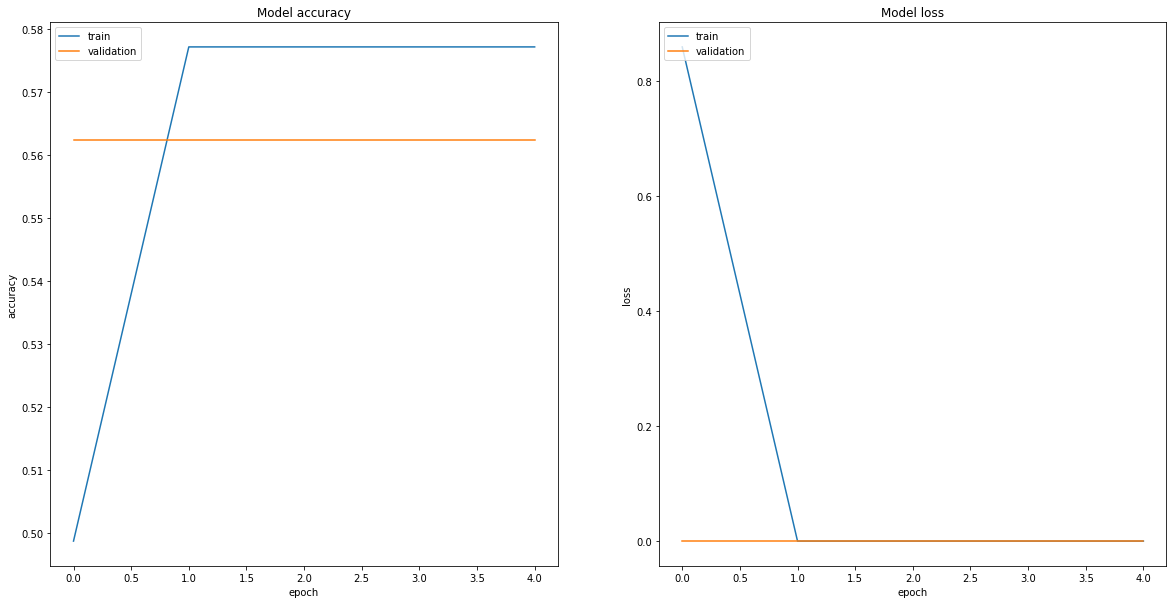

In [16]:
fig = plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.show()

# Save the model

In [17]:
model.save(model_save_path)

## Restore the model

In [18]:
# model = keras.models.load_model(model_save_path)

# model.trainable = False
# model.compile()

## Predict on one image

In [19]:
image_array = x[0]
test_batch = image_array.reshape((1,) + image_array.shape)

preds = model.predict(test_batch)
preds.shape

(1, 256, 256, 3)

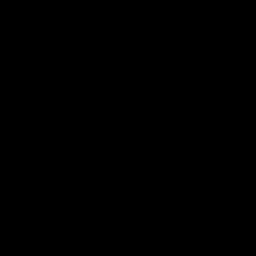

In [20]:
array_to_img(preds[0])

In [23]:
np.argmax(preds, axis=3)

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]])

In [26]:
np.unique(np.argmax(preds, axis=3))

array([0])

In [35]:
np.min(array_to_img(preds[0])), np.max(array_to_img(preds[0]))

(0, 0)